Please note that this tutorial assumes you are already familiar
with technical details of kESI implementation.  If you are not,
consider running its expanded version
`tutorial_four_spheres_basics_explained.ipynb` instead.

# Model

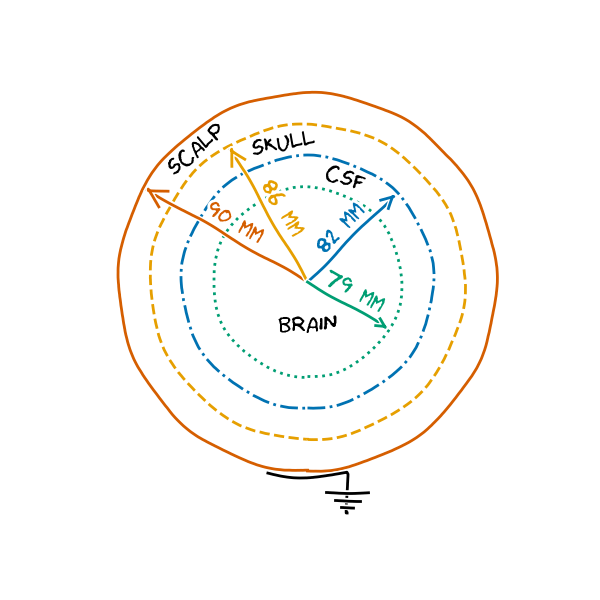

| Volume | Conductivity |
|:-------|:-------------|
| Scalp  |  330 mS / m  |
| Skull  | 16.5 mS / m  |
| CSF    | 1560 mS / m  |
| Brain  |  330 mS / m  |

# Requirements

## Memory

The code of the notebook requires at least 7.0 GB (6.6 <!-- 6.5 --> GiB) of free memory.


## Environment

1. Anaconda Python distribution (tested with `Miniconda3-py39_4.12.0-Linux-x86_64.sh`, _conda v. 4.12.0_).
2. Jupyter server (see `extras/jupyter_server.sh` for details).
3. Anaconda environments (run `setup_conda_envs.sh`).
4. gmsh (not necessary if you already have meshes in either MSH or XDMF format).


## Setup

### Mesh

You need to have a mesh in XDMF format.  Try:

    cd extras
    conda activate kesi3.7
    snakemake data/generated/meshes/four_spheres_csf_3_mm__plain/normal.xdmf -j 1

<!-- For normal: --><!-- It may take a while (10 s.  )-->
At least 137 MB (131 MiB) of free memory is necessary.
<!-- For fine: 1 min; 201388 kiB--> 

### Model properties

We are going to use properties from the
`data/bundled/model_properties/four_spheres_csf_3_mm__Naess_Chintaluri_2017.ini` file.

### Electrodes

We are going to use a subset of positions of point electrodes defined in
`data/bundled/electrode_locations/tutorial/four_spheres.csv`:

    NAME,X,Y,Z
    LB_06,-0.050390726558384745,0.0065935887274778905,-0.024147041492297946
    LB_11,-0.06549072655838475,0.0034935887274778893,-0.018847041492297947
    LP_01,-0.05379072655838474,0.0006935887274778896,-0.009447041492297949

Write the positions as `data/generated/tutorial/four_spheres/tutorial_electrodes.csv`
(you may also use the superset file in the preprocessing instead).

# Preprocessing

## Calculation of the leadfield correction

For every electrode we use Finite Element Method (FEM) to calculate the leadfield correction:

    cd extras
    mkdir -p data/generated/tutorial/four_spheres/fenics_leadfield_corrections
    python solve_sphere_on_plate.py \
      --mesh data/generated/meshes/four_spheres_csf_3_mm__plain/normal.xdmf \
      --degree 1 \
      --config data/bundled/model_properties/four_spheres_csf_3_mm__Naess_Chintaluri_2017.ini \
      --grounded-plate-edge-z -0.088 \
      --electrodes data/generated/tutorial/four_spheres/tutorial_electrodes.csv \
      --name LB_06 \
      --output data/generated/tutorial/four_spheres/fenics_leadfield_corrections/LB_06.ini
    python solve_sphere_on_plate.py \
      --mesh data/generated/meshes/four_spheres_csf_3_mm__plain/normal.xdmf \
      --degree 1 \
      --config data/bundled/model_properties/four_spheres_csf_3_mm__Naess_Chintaluri_2017.ini \
      --grounded-plate-edge-z -0.088 \
      --electrodes data/generated/tutorial/four_spheres/tutorial_electrodes.csv \
      --name LB_11 \
      --output data/generated/tutorial/four_spheres/fenics_leadfield_corrections/LB_11.ini
    python solve_sphere_on_plate.py \
      --mesh data/generated/meshes/four_spheres_csf_3_mm__plain/normal.xdmf \
      --degree 1 \
      --config data/bundled/model_properties/four_spheres_csf_3_mm__Naess_Chintaluri_2017.ini \
      --grounded-plate-edge-z -0.088 \
      --electrodes data/generated/tutorial/four_spheres/tutorial_electrodes.csv \
      --name LP_01 \
      --output data/generated/tutorial/four_spheres/fenics_leadfield_corrections/LP_01.ini

<!--It may take a while (3 x 3 s).  -->At least 195 MB (186 MiB) of free memory is required.

> Note, that for spherical geometries a dedicated tool
> `solve_sphere_on_plate.py` is used, with an
> additional parameter `--grounded-plate-edge-z`
> (Z-coordinate of the edge of the grounded plate).

# TODO BELOW

## Sampling of the leadfield correction

We sample the correction on NxNxN grid, where `N = 2**K + 1`:

    mkdir -p data/generated/tutorial/four_spheres/sampled_leadfield_corrections
    python create_grid.py \
      --grid data/generated/tutorial/four_spheres/leadfield_correction_grid.npz \
      --start -0.079 \
      --end 0.079 \
      -k 7 \
      --lazy
    python sample_spherical_solution.py \
      --fill 0 \
      --sampling-radius 0.079 \
      --grid data/generated/tutorial/four_spheres/leadfield_correction_grid.npz \
      --config data/generated/tutorial/four_spheres/fenics_leadfield_corrections/LB_06.ini \
      --output data/generated/tutorial/four_spheres/sampled_leadfield_corrections/LB_06.npz
    python sample_spherical_solution.py \
      --fill 0 \
      --sampling-radius 0.079 \
      --grid data/generated/tutorial/four_spheres/leadfield_correction_grid.npz \
      --config data/generated/tutorial/four_spheres/fenics_leadfield_corrections/LB_11.ini \
      --output data/generated/tutorial/four_spheres/sampled_leadfield_corrections/LB_11.npz
    python sample_spherical_solution.py \
      --fill 0 \
      --sampling-radius 0.079 \
      --grid data/generated/tutorial/four_spheres/leadfield_correction_grid.npz \
      --config data/generated/tutorial/four_spheres/fenics_leadfield_corrections/LP_01.ini \
      --output data/generated/tutorial/four_spheres/sampled_leadfield_corrections/LP_01.npz

It may take a while<!-- (3 x 35 s)-->.  At least 209 MB (200 MiB) of free memory is required.

> Note, that for spherical geometries a dedicated tool
> `sample_spherical_solution.py` is used.

| Parameter  | Description  |
|:------------|:--------------|
| `-k`   | binary logarithm of sample number in each dimansion (which is `2**k + 1`) |
| `--fill` | fill value for points where solution cannot be sampled |
| `--sampling-radius` | radius of the sampled sphere |
| `--config` | the solution metadata |
| `--output` | file for the sampled solution |

# Kernel construction tools

## Electrode object

In [ ]:
from kesi.kernel.electrode import LinearlyInterpolatedLeadfieldCorrection as Electrode

# # The interpolation can be speeded up at the cost of precision by changing
# # the class to `NearestNeighbourInterpolatedLeadfieldCorrection`:
# from kesi.kernel.electrode import NearestNeighbourInterpolatedLeadfieldCorrection as Electrode

In [ ]:
electrodes = [Electrode(f"data/generated/tutorial/four_spheres/sampled_leadfield_corrections/{name}.npz")
              for name in ["LB_06", "LB_11", "LP_01"]]

## Model source

We want to use CSD bases 18mm wide ($R = 9mm$).

In [ ]:
from kesi.common import SphericalSplineSourceKCSD


def get_model_source(radius):
    spline_nodes = [radius / 3, radius]
    spline_polynomial_coefficients = [[1],
                                      [0,
                                       6.75 / radius,
                                       -13.5 / radius ** 2,
                                       6.75 / radius ** 3]]
    return SphericalSplineSourceKCSD(0, 0, 0,
                                     spline_nodes,
                                     spline_polynomial_coefficients)

In [ ]:
SRC_R = 9e-3

model_src = get_model_source(SRC_R)

## Convolver object

In [ ]:
from kesi.kernel.constructor import Convolver

import numpy as np


BRAIN_RADIUS = 0.079
ROMBERG_K = 5

_h_min = SRC_R * 2**(1 - ROMBERG_K)
_X = _Y = np.linspace(-BRAIN_RADIUS, BRAIN_RADIUS, int(np.floor(2 * BRAIN_RADIUS / _h_min)) + 1)
_Z = np.linspace(-0.5 * BRAIN_RADIUS, BRAIN_RADIUS, int(np.floor(1.5 * BRAIN_RADIUS / _h_min)) + 1)

_pot_grid = [_X, _Y, _Z]
_csd_grid = [_X, _Y, _Z]

convolver = Convolver(_pot_grid, _csd_grid)

for _c, _h in zip("XYZ", convolver.steps("POT")):
    assert _h >= _h_min, f"{_c}:\t{_h} < {_h_min}"
    if _h >= 2 * _h_min:
        print(f"You can reduce number of nodes of quadrature for {_c} dimension")

In [ ]:
print(convolver.csd_shape)

In [ ]:
for name in ['POT', 'CSD', 'SRC']:
    print(f'{name} grid')
    print('  shape:', convolver.shape(name))
    print('  spacing:', convolver.steps(name))

## Convolver interface

We include only CSD bases which supports fit in the brain
and which centroid lies in the upper hemisphere.

In [ ]:
from kesi.kernel.constructor import ConvolverInterfaceIndexed

from scipy.integrate import romb


ROMBERG_N = 2 ** ROMBERG_K + 1
ROMBERG_WEIGHTS = romb(np.identity(ROMBERG_N), dx=2 ** -ROMBERG_K)

SRC_MASK = ((convolver.SRC_Z > SRC_R - 0.5 * BRAIN_RADIUS)
            & (np.sqrt(np.square(convolver.SRC_X)
                       + np.square(convolver.SRC_Y)
                       + np.square(convolver.SRC_Z)) < BRAIN_RADIUS - SRC_R))

In [ ]:
print(SRC_MASK.sum())

In [ ]:
convolver_interface = ConvolverInterfaceIndexed(convolver,
                                                model_src.csd,
                                                ROMBERG_WEIGHTS,
                                                SRC_MASK)

## Potential Basis Functions object

### Potential Basis Functions: analytical solution of the forward problem (kCSD)

In [ ]:
import kesi.kernel.potential_basis_functions as pbf

In [ ]:
pbf_kcsd = pbf.Analytical(convolver_interface,
                          potential=model_src.potential)

### Potential Basis Functions: numerically corrected analytical solution of the forward problem (kESI)

In [ ]:
pbf_kesi = pbf.AnalyticalCorrectedNumerically(convolver_interface,
                                              potential=model_src.potential)

## Kernel constructor and cross-kernel constructor

In [ ]:
from kesi.kernel.constructor import KernelConstructor, CrossKernelConstructor

In [ ]:
kernel_constructor = KernelConstructor()

In [ ]:
CSD_MASK = np.ones(convolver.shape('CSD'),
                   dtype=bool)

In [ ]:
kernel_constructor.crosskernel = CrossKernelConstructor(convolver_interface,
                                                        CSD_MASK)

In [ ]:
def to_3D(CSD):
    return CSD.reshape(convolver.shape('CSD'))

# kCSD reconstructor

## Construction of kernels

In [ ]:
%%time
B_KCSD = kernel_constructor.potential_basis_functions_at_electrodes(electrodes,
                                                                    pbf_kcsd)

In [ ]:
KERNEL_KCSD = kernel_constructor.kernel(B_KCSD)

In [ ]:
%%time
CROSSKERNEL_KCSD = kernel_constructor.crosskernel(B_KCSD)

In [ ]:
del B_KCSD  # the array is large and no longer needed

## Reconstructor object

In [ ]:
from kesi._verbose import _CrossKernelReconstructor as Reconstructor
from kesi._engine import _LinearKernelSolver as KernelSolver

In [ ]:
reconstructor_kcsd = Reconstructor(KernelSolver(KERNEL_KCSD),
                                   CROSSKERNEL_KCSD)

# Visualisation

In [ ]:
import matplotlib.pyplot as plt

from local import cbf
from local.tutorial.view import FourSpheres as CoordinatePlanesVisualisation

In [ ]:
csd_grid = [_x.flatten() for _x in convolver.CSD_GRID]

In [ ]:
csd_plotter = CoordinatePlanesVisualisation(csd_grid,
                                            [-0.0566, 0.0036, -0.0175],
                                            unit_factor=1e-3,
                                            unit='$\\frac{pA}{mm^3}$',
                                            length_factor=1e3,
                                            length_unit='$mm$')

# Ground truth CSD and its potential at the electrodes

## GT CSD

In [ ]:
%%time
EIGENVALUES_KCSD, EIGENVECTORS_KCSD = np.linalg.eigh(KERNEL_KCSD)
EIGENVALUES_KCSD, EIGENVECTORS_KCSD = EIGENVALUES_KCSD[::-1], EIGENVECTORS_KCSD[:, ::-1]

GT_CSD = to_3D(reconstructor_kcsd(EIGENVECTORS_KCSD[:, 0] * 10))

In [ ]:
csd_plotter.plot_volume(GT_CSD, 'GT CSD')

## FEM forward modelling

In [ ]:
import scipy.interpolate as si

from local.tutorial import SphericalForwardModel as ForwardModel

In [ ]:
%%time
fem = ForwardModel("data/generated/meshes/four_spheres_csf_3_mm__plain/normal.xdmf",
                   1,
                   "data/bundled/model_properties/four_spheres_csf_3_mm__Naess_Chintaluri_2017.ini")

It may take more than 3 minutes.

In [ ]:
%%time
_csd = si.RegularGridInterpolator(csd_grid,
                                  GT_CSD,
                                  bounds_error=False,
                                  fill_value=0)
potential = fem(_csd)

del _csd  # the object is large and no longer needed

It may take more than 2 minutes.

We visualise the potential.

In [ ]:
potential_plotter = CoordinatePlanesVisualisation(csd_grid,
                                                  [0.01, 0, 0.065],
                                                  unit='$\mu{}V$',
                                                  length_factor=1e3,
                                                  length_unit='$mm$',
                                                  cmap=cbf.PRGn)

In [ ]:
%%time
V_PLANES = []

for _X, _Y, _Z in potential_plotter.PLANES_XYZ:
    with np.nditer([np.reshape(_X, (-1, 1, 1)),
                    np.reshape(_Y, (1, -1, 1)),
                    np.reshape(_Z,  (1, 1, -1)),
                    None]) as it:
        for _x, _y, _z, _res in it:
            try:
                _res[...] = potential(_x, _y, _z)
            except RuntimeError:
                _res[...] = np.nan

        V_PLANES.append(np.ma.masked_invalid(it.operands[3]))

It may take more than a minute.

In [ ]:
potential_plotter.plot_planes(V_PLANES, 'POTENTIAL')

We probe the potential at electrodes.

In [ ]:
GT_V = np.array([potential(_e.x, _e.y, _e.z) for _e in electrodes])

In [ ]:
del potential, fem  # these objects are large and no longer needed

# Reconstruction

## kCSD

In [ ]:
CSD_KCSD = to_3D(reconstructor_kcsd(GT_V))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KCSD,
                            'kCSD')

The reconstruction is mostly error.

In [ ]:
del CSD_KCSD  # the array is large and no longer needed

In [ ]:
del reconstructor_kcsd, CROSSKERNEL_KCSD  # these objects are large and no longer needed

## kESI

In [ ]:
%%time
B_KESI = kernel_constructor.potential_basis_functions_at_electrodes(electrodes,
                                                                    pbf_kesi)

It may take more than a minute.

In [ ]:
KERNEL_KESI = kernel_constructor.kernel(B_KESI)

In [ ]:
%%time
CROSSKERNEL_KESI = kernel_constructor.crosskernel(B_KESI)

In [ ]:
del B_KESI  # the array is large and no longer needed

In [ ]:
reconstructor_kesi = Reconstructor(KernelSolver(KERNEL_KESI),
                                   CROSSKERNEL_KESI)

In [ ]:
CSD_KESI = to_3D(reconstructor_kesi(GT_V))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI,
                            'kESI')

The reconstruction is pretty close to the ground truth.  Note that kESI is at disadvantage, as ground truth CSD is an eigensource of kCSD.

In [ ]:
del CSD_KESI  # the array is large and no longer needed

## Noise

As no real-world measurement is perfect, we introduce 2% noise to see, how kESI may deal with it:

In [ ]:
np.random.seed(42)
V_WITH_NOISE = np.random.normal(loc=GT_V,
                                scale=0.02*np.sqrt(np.square(GT_V).mean()))

In [ ]:
CSD_KESI_WITH_NOISE = to_3D(reconstructor_kesi(V_WITH_NOISE))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI_WITH_NOISE,
                            'kESI (noise)')

In [ ]:
del CSD_KESI_WITH_NOISE  # the array is large and no longer needed

As you can see, the quality of reconstruction decreased significatntly.

## Regularization

In [ ]:
EIGENVALUES_KESI = np.linalg.eigvalsh(KERNEL_KESI)[::-1]

In [ ]:
plt.plot(EIGENVALUES_KESI,
         marker='o')

plt.yscale('log')

In [ ]:
REGULARIZATION_PARAMETERS = np.logspace(5, 13, 8 * 10 + 1)

### Leave-one-out cross-validation

In [ ]:
from kesi.common import cv

In [ ]:
%%time
CV_ERRORS = cv(reconstructor_kesi, V_WITH_NOISE, REGULARIZATION_PARAMETERS)

In [ ]:
regularization_parameter_idx = np.argmin(CV_ERRORS)
regularization_parameter = REGULARIZATION_PARAMETERS[regularization_parameter_idx]

In [ ]:
plt.plot(REGULARIZATION_PARAMETERS,
         CV_ERRORS,
         color=cbf.BLUE)
plt.plot(regularization_parameter,
         min(CV_ERRORS),
         marker="o",
         color=cbf.BLUE)
plt.axvspan(EIGENVALUES_KESI.min(),
            EIGENVALUES_KESI.max(),
            ls=":",
            color=cbf.GREEN,
            hatch=".....",
            fill=False)
plt.xscale('log')
plt.xlabel('regularization parameter')
plt.yscale('log')
plt.ylabel('L2 norm of cross-validation error')

In [ ]:
CSD_KESI_CV = to_3D(reconstructor_kesi(V_WITH_NOISE, regularization_parameter))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI_CV,
                            'kESI (noise)')

In [ ]:
del CSD_KESI_CV  # the array is large and no longer needed

### L-curve

In [ ]:
model_norm = []
error = []
for _regularization_parameter in REGULARIZATION_PARAMETERS:
    _beta = np.linalg.solve(KERNEL_KESI + _regularization_parameter * np.identity(len(electrodes)),
                            V_WITH_NOISE)
    _V = np.matmul(KERNEL_KESI, _beta)
    error.append(np.sqrt(np.square(V_WITH_NOISE - _V).mean()))
    model_norm.append(np.dot(_beta, _V))

In [ ]:
_idx_low, _idx_high = np.searchsorted(REGULARIZATION_PARAMETERS,
                                      [EIGENVALUES_KESI.min(),
                                       EIGENVALUES_KESI.max()])
_bottom = model_norm[_idx_high]
_top = model_norm[_idx_low]
_left = error[_idx_low]
_right = error[_idx_high]

fig, ax = plt.subplots()
ax.plot(error, model_norm,
        marker='.',
        color=cbf.BLUE)
ax.add_patch(plt.Rectangle((_left, _bottom),
                           _right - _left,
                           _top - _bottom,
                           ls=':',
                           edgecolor=cbf.BLACK,
                           facecolor='none'))

ax.set_yscale('log')
ax.set_ylabel('norm of the model')
ax.set_xscale('log')
ax.set_xlabel('L2 norm of the prediction error')
ax.set_title('L-curve')


fig, ax = plt.subplots()
ax.plot(error, model_norm,
        marker='.',
        color=cbf.BLUE)
ax.plot(error[regularization_parameter_idx],
        model_norm[regularization_parameter_idx],
        marker='o',
        color=cbf.VERMILION)
ax.annotate(f'$\\lambda$ = {regularization_parameter:.2e}\n(selected by CV)',
            (error[regularization_parameter_idx],
             model_norm[regularization_parameter_idx]),
            xytext=(25, -50),
            textcoords='offset points',
            arrowprops={'facecolor': cbf.BLACK,
                        'shrink': 0.1,
                        'headwidth': 6,
                        'width': 2,
                       })

ax.set_yscale('log')
ax.set_ylabel('norm of the model')
ax.set_xscale('log')
ax.set_xlabel('L2 norm of the prediction error')
ax.set_xlim(_left, _right)
ax.set_ylim(_bottom, _top)
_ = ax.set_title('L-curve cropped to the range of eigenvalues')